In [1]:
import os
import csv
import pymysql as mc 
import time
import webbrowser
import sys
from sklearn.cluster import KMeans
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.preprocessing import scale

In [2]:
cnx = mc.connect(user='akashgoyal',password='******',
                 host='stromberg.cs.uchicago.edu',db='mlb_practicum',port=3306)

In [3]:
#reclassify all the pitch_types
def reclassify_pitches(df):
    #takes a current DF and returns a new DF with additional column 
    four_seam = ['FF','FA']
    slider = ['SL']
    two_seam = ['FT']
    change_up = ['CH']
    sinker = ['SI','FS']
    knuckleball = ['KN']
    curve = ['CU','KC']
    cutter = ['FC']
    na = ['IN','PO','FO','EP','SC','UN','AB']
    l = []
    i = 2
    
    for row in df.itertuples():
        if row[i] in four_seam:
            l.append('four_seam')
        elif row[i] in slider:
            l.append('slider')
        elif row[i] in two_seam:
            l.append('two_seam')
        elif row[i] in change_up:
            l.append('change_up')
        elif row[i] in sinker:
            l.append('sinker')
        elif row[i] in knuckleball:
            l.append('knuckleball')
        elif row[i] in curve:
            l.append('curve')
        elif row[i] in cutter:
            l.append('cutter')
        else:
            l.append(None)
    df['new_pitch_type']=l 
    return df

In [4]:
query = 'SELECT pitcherID, pitchType FROM Pitch2'
df = pd.read_sql_query(query,cnx)
#reclassify_pitches(df)

In [5]:
reclassify_pitches(df)
query2 = 'SELECT playerID, CONCAT(firstName," ",lastName) AS playerName FROM Player'
player_name_df = pd.read_sql_query(query2,cnx)

In [6]:
df.head()

,pitcherID,pitchType,new_pitch_type
0,450308,FF,four_seam
1,450308,CU,curve
2,450308,SL,slider
3,450308,FT,two_seam
4,450308,SL,slider


In [7]:
#create a dictionary of playerID to playerName
player_dict = {}
for i in range(len(player_name_df)):
    p_id = player_name_df.iloc[i,0]
    if not player_dict.get(p_id):
        player_dict[p_id] = player_name_df.iloc[i,1]

In [8]:
#this will take in a dataframe and return a new Dataframe with
#pitcherID, totalPitches, %fastballs, %sliders, %changeup, etc
table = pd.pivot_table(df,values=['new_pitch_type'],columns=['new_pitch_type'],
                       index=['pitcherID'],aggfunc='count')

In [9]:
#change the NA's to 0's
table.fillna(value=0,inplace=True)

In [10]:
#convert counts to percentages and create a new dataframe
players = {}
for row in table.itertuples():
    total = 0
    freqList = []
    for i in range(1,9):
        total+=row[i]
    
    for i in range(1,9):
        freqList.append(row[i]/total)
    
    freqList.append(total)
            
    players[row[0]] = freqList

In [11]:
#prepare the new dataframe for KMeans 
player_df = pd.DataFrame.from_dict(players,orient='index')
player_df.columns=["change_up","curve","cutter","four_seam",
                   "knuckleball","sinker","slider","two_seam","total_pitches"]
condensed_df = player_df[player_df['total_pitches']>100]
condensed_df = condensed_df.drop('total_pitches',axis=1)

In [12]:
#map each of the index playerID to a name
l = []
for pId in condensed_df.index.values:
    l.append(player_dict[pId])

In [13]:
#add name to dataframe and create the index
condensed_df['playerName'] = l
condensed_df.set_index('playerName',inplace=True)
condensed_df

,change_up,curve,cutter,four_seam,knuckleball,sinker,slider,two_seam
playerName,,,,,,,,
Bo Schultz,0.022750,0.000000,0.124629,0.472799,0.0,0.000000,0.179031,0.200791
Cody Anderson,0.249559,0.362434,0.078042,0.309965,0.0,0.000000,0.000000,0.000000
Jesen Therrien,0.022364,0.000000,0.000000,0.300319,0.0,0.000000,0.437700,0.239617
Andrew Carignan,0.010169,0.000000,0.016949,0.830508,0.0,0.000000,0.142373,0.000000
Chris Rusin,0.190211,0.080884,0.163833,0.174321,0.0,0.325600,0.065152,0.000000
Mitch Atkins,0.062069,0.133333,0.071264,0.443678,0.0,0.000000,0.262069,0.027586
Ryan Vogelsong,0.130073,0.184669,0.000069,0.324870,0.0,0.000069,0.170031,0.190219
Dylan Floro,0.045093,0.007958,0.005305,0.108753,0.0,0.594164,0.238727,0.000000
Burke Badenhop,0.002716,0.000170,0.000170,0.011883,0.0,0.804787,0.180275,0.000000


In [14]:
condensed_df.to_csv('Pitcher_Percentages.csv')

In [45]:
X = condensed_df.values

In [63]:
clf2 = MeanShift()
clf2.fit(X)
centers = clf2.cluster_centers_
labels = clf2.labels_
np.unique(labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([740, 202,   8,   3,   2,   1,   1,   1,   1,   1]))

In [42]:
condensed_df[condensed_df['classifications_scaled']==2]

,change_up,curve,cutter,four_seam,knuckleball,sinker,slider,two_seam,classifications,classifications_scaled
playerName,,,,,,,,,,
Dan Haren,0.000000,0.088198,0.385342,0.293942,0.0,0.139070,0.000000,0.093448,0,2
Rich Thompson,0.026442,0.190705,0.519231,0.263622,0.0,0.000000,0.000000,0.000000,0,2
Mark Melancon,0.000891,0.253044,0.408375,0.307098,0.0,0.016484,0.000000,0.014108,0,2
Mariano Rivera,0.000349,0.000000,0.870112,0.129190,0.0,0.000000,0.000000,0.000349,0,2
Kenley Jansen,0.002777,0.000000,0.719482,0.198386,0.0,0.000000,0.078164,0.001190,0,2
Andy Sonnanstine,0.000000,0.269929,0.525014,0.091809,0.0,0.000000,0.113249,0.000000,0,2
David Robertson,0.014260,0.230407,0.494402,0.118798,0.0,0.000000,0.140483,0.001650,0,2
Bryan Shaw,0.011025,0.009647,0.660557,0.120728,0.0,0.000000,0.198043,0.000000,0,2


In [43]:
class agKMeans(KMeans):
    def __init__(self,df,fraction=1):
        df_samp = df.sample(frac=fraction,random_state=1)
        self.df = df_samp
        self.y_kmeans = None
        self.kmeans = None
        self.plot = None
        
    def createCluster(self,number_clusters):
        kmeans = KMeans(n_clusters=number_clusters)
        kmeans.fit(self.df)
        y_kmeans = kmeans.predict(self.df)
        #self.kmeans = kmeans
        self.y_kmeans = y_kmeans 
        return  y_kmeans#,kmeans
    
    #don't use these two functions below this is 8 dimensional space
    def generatePlot(self,xColumn,yColumn):
        plt.scatter(self.df[xColumn],self.df[yColumn],c=self.y_kmeans,s=50,cmap='viridis')
        centers = self.kmeans.cluster_centers_
        plt.scatter(centers[:,0],centers[:,1],c='black',s=200,alpha=0.5)
        
    def showScatterPlot(self,xColumn,yColumn):
        plt.scatter(self.df[xColumn],self.df[yColumn])

Text(0.5,1,'Elbow Curve')

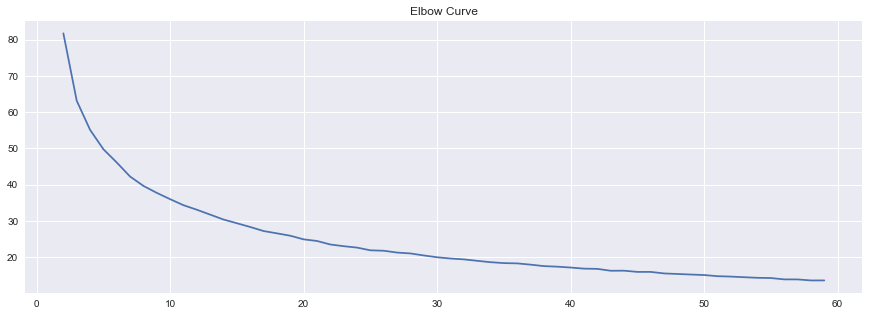

In [143]:
#https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method
# used Ahmed Besbes's answer
distortions=[]
for k in range(2,60):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rel_df)
    distortions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15,5))
plt.plot(range(2,60),distortions)
plt.grid(True)
plt.title('Elbow Curve')

In [16]:
#This part is just to find a good cutoff point for minimum pitch count for inclusion

l = []
for i in range(0,1000,100):
    query = "SELECT pitcherID, COUNT(*) FROM Pitch2 GROUP BY pitcherID HAVING COUNT(*)>"+str(i)
    l.append(len(pd.read_sql_query(query,cnx)))
x = np.linspace(0,20000,21)
plt.scatter(x,l)
plt.xlabel('number of pitches')
plt.ylabel('number of pitchers')
plt.title('Number of Pitchers vs. Total Pitch Count')


'\nl = []\nfor i in range(0,1000,100):\n    query = "SELECT pitcherID, COUNT(*) FROM Pitch2 GROUP BY pitcherID HAVING COUNT(*)>"+str(i)\n    l.append(len(pd.read_sql_query(query,cnx)))\nx = np.linspace(0,20000,21)\nplt.scatter(x,l)\nplt.xlabel(\'number of pitches\')\nplt.ylabel(\'number of pitchers\')\nplt.title(\'Number of Pitchers vs. Total Pitch Count\')\n'